**Setup & Mount Drive**

In [4]:
# Install (safe to re-run)
!pip install -q torchmetrics

# Correct import for recent versions
try:
    from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
except Exception:
    # Fallback for older torchmetrics
    from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure


In [7]:
# ==============================
# UMR-GAN TESTING NOTEBOOK
# ==============================

!pip install -q torch torchvision albumentations torchmetrics matplotlib opencv-python-headless pandas

import os, glob, json, cv2, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import pandas as pd

# Mount Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print("Colab mount skipped:", e)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Mounted at /content/drive
Device: cpu


**Paths**

In [8]:
TEST_DIR   = "/content/drive/MyDrive/Testing"   # your held-out images (clean GT)
RESULTS_DIR = "/content/drive/MyDrive/UMR_GAN/results"
MODEL_PATH  = f"{RESULTS_DIR}/umr_pix2pix_inpaint_ssim_G.pth"

EVAL_DIR = os.path.join(RESULTS_DIR, "eval")
os.makedirs(EVAL_DIR, exist_ok=True)

print("TEST_DIR   :", TEST_DIR)
print("MODEL_PATH :", MODEL_PATH)
print("EVAL_DIR   :", EVAL_DIR)


TEST_DIR   : /content/drive/MyDrive/Testing
MODEL_PATH : /content/drive/MyDrive/UMR_GAN/results/umr_pix2pix_inpaint_ssim_G.pth
EVAL_DIR   : /content/drive/MyDrive/UMR_GAN/results/eval


**Test Dataset & Loader**

In [9]:
# Albumentations transform: resize -> normalize to [-1,1] -> tensor
TF = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),  # -> [-1,1]
    ToTensorV2()
])

def load_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # uint8 [0..255]
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return img

class MRITestSet(Dataset):

    def __init__(self, root, noise_sigma=15.0):
        self.files = sorted(
            glob.glob(os.path.join(root, "**", "*.png"), recursive=True)
            + glob.glob(os.path.join(root, "**", "*.jpg"), recursive=True)
            + glob.glob(os.path.join(root, "**", "*.jpeg"), recursive=True)
        )
        if len(self.files) == 0:
            raise FileNotFoundError(f"No images found under: {root}")
        self.noise_sigma = noise_sigma
        print(f"Found {len(self.files)} test images.")

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path  = self.files[idx]
        clean = load_gray(path)                                        # uint8
        noisy = np.clip(clean + np.random.normal(0, self.noise_sigma, clean.shape), 0, 255).astype(np.uint8)

        # To tensors in [-1,1] with shape (1,H,W)
        noisy_t = TF(image=noisy)["image"]
        clean_t = TF(image=clean)["image"]
        return noisy_t, clean_t, path

test_ds = MRITestSet(TEST_DIR, noise_sigma=15.0)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)


Found 1311 test images.


**Model definition (Generator only; in_c=2, out_c=1)**

In [10]:
class UNetGenerator(nn.Module):
    def __init__(self, in_c=2, out_c=1):
        super().__init__()
        def down(i,o,bn=True):
            layers=[nn.Conv2d(i,o,4,2,1,bias=False)]
            if bn: layers.append(nn.BatchNorm2d(o))
            layers.append(nn.LeakyReLU(0.2,True))
            return nn.Sequential(*layers)
        def up(i,o,drop=False):
            layers=[nn.ConvTranspose2d(i,o,4,2,1,bias=False),
                    nn.BatchNorm2d(o), nn.ReLU(True)]
            if drop: layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.d1=down(in_c,64,False); self.d2=down(64,128)
        self.d3=down(128,256); self.d4=down(256,512)
        self.d5=down(512,512); self.d6=down(512,512)
        self.d7=down(512,512); self.b=down(512,512, bn=False)  # no BN at 1x1

        self.u1=up(512,512,True); self.u2=up(1024,512,True)
        self.u3=up(1024,512,True); self.u4=up(1024,512)
        self.u5=up(1024,256); self.u6=up(512,128)
        self.u7=up(256,64)
        self.out=nn.Sequential(nn.ConvTranspose2d(128,out_c,4,2,1), nn.Tanh())

    def forward(self,x):
        d1=self.d1(x); d2=self.d2(d1); d3=self.d3(d2); d4=self.d4(d3)
        d5=self.d5(d4); d6=self.d6(d5); d7=self.d7(d6); b=self.b(d7)
        u1=self.u1(b); u2=self.u2(torch.cat([u1,d7],1))
        u3=self.u3(torch.cat([u2,d6],1)); u4=self.u4(torch.cat([u3,d5],1))
        u5=self.u5(torch.cat([u4,d4],1)); u6=self.u6(torch.cat([u5,d3],1))
        u7=self.u7(torch.cat([u6,d2],1))
        return self.out(torch.cat([u7,d1],1))

# Load trained weights
G = UNetGenerator(in_c=2, out_c=1).to(device)
G.load_state_dict(torch.load(MODEL_PATH, map_location=device))
G.eval()
print("Loaded weights:", MODEL_PATH)


Loaded weights: /content/drive/MyDrive/UMR_GAN/results/umr_pix2pix_inpaint_ssim_G.pth


**Helpers (denorm + triplet saver)**

In [11]:
def denorm01(t):
    """[-1,1] tensor -> [0,1] numpy (H,W)"""
    return t.squeeze().detach().cpu().numpy() * 0.5 + 0.5

def save_triplet(noisy_t, restored_t, clean_t, out_path):
    fig, ax = plt.subplots(1,3,figsize=(9,3))
    for a,img,title in zip(
        ax,
        [denorm01(noisy_t), denorm01(restored_t), denorm01(clean_t)],
        ["Input (noisy/masked)", "Restored", "Clean"]
    ):
        a.imshow(img, cmap="gray"); a.set_title(title); a.axis("off")
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

**Evaluate - Baseline vs Model (denoise mode, zero mask)**

In [12]:
# Metrics expect data_range to match [-1,1] -> 2.0
psnr = PeakSignalNoiseRatio(data_range=2.0).to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=2.0).to(device)

P_base, S_base = [], []
P_model, S_model = [], []

# Evaluate
with torch.no_grad():
    for i, (noisy, clean, path) in enumerate(test_dl):
        noisy = noisy.to(device)    # (B,1,H,W)
        clean = clean.to(device)    # (B,1,H,W)

        # ---- Baseline: compare noisy vs clean ----
        P_base.append(psnr(noisy, clean).item())
        S_base.append(ssim(noisy, clean).item())

        # ---- Model: zero-mask denoising ----
        zero_mask = torch.zeros_like(noisy)        # (B,1,H,W)
        x_cond = torch.cat([noisy, zero_mask], dim=1)  # (B,2,H,W)
        restored = G(x_cond)

        P_model.append(psnr(restored, clean).item())
        S_model.append(ssim(restored, clean).item())

        # Save first 6 triplets
        if i < 6:
            base = os.path.splitext(os.path.basename(path[0]))[0]
            out_png = os.path.join(EVAL_DIR, f"triplet_denoise_{i+1}_{base}.png")
            save_triplet(noisy[0], restored[0], clean[0], out_png)

avg_base_psnr = float(np.mean(P_base));  avg_base_ssim = float(np.mean(S_base))
avg_model_psnr = float(np.mean(P_model)); avg_model_ssim = float(np.mean(S_model))

print(f"BASELINE  (Noisy→Clean): PSNR {avg_base_psnr:.2f} dB | SSIM {avg_base_ssim:.3f}")
print(f"UMR-GAN   (Restored→Clean): PSNR {avg_model_psnr:.2f} dB | SSIM {avg_model_ssim:.3f}")
print(f"DELTA                 : ΔPSNR {avg_model_psnr-avg_base_psnr:+.2f} dB | ΔSSIM {avg_model_ssim-avg_base_ssim:+.3f}")


BASELINE  (Noisy→Clean): PSNR 30.19 dB | SSIM 0.749
UMR-GAN   (Restored→Clean): PSNR 34.23 dB | SSIM 0.918
DELTA                 : ΔPSNR +4.04 dB | ΔSSIM +0.169


**Inpainting showcase (creates masks and evaluates)**

In [14]:
DO_INPAINT_SHOWCASE = True  # set False to skip

def random_mask(h, w):
    M = np.zeros((h, w), dtype=np.uint8)
    # one rectangle hole
    rh, rw = int(h*0.20), int(w*0.20)
    ry, rx = np.random.randint(0, h-rh+1), np.random.randint(0, w-rw+1)
    M[ry:ry+rh, rx:rx+rw] = 1
    return M

if DO_INPAINT_SHOWCASE:
    with torch.no_grad():
        for i, (noisy, clean, path) in enumerate(test_dl):
            if i == 3: break  # save 3 examples
            b, _, H, W = noisy.shape
            M = random_mask(H, W)  # 0/1 mask
            M_t = torch.from_numpy(M).float().to(device).view(1,1,H,W)
            masked = noisy.clone().to(device)
            masked[M_t.bool()] = -1.0  # blank the hole to -1 (normalized 0)
            x_cond = torch.cat([masked, M_t], dim=1)
            restored = G(x_cond)

            base = os.path.splitext(os.path.basename(path[0]))[0]
            out_png = os.path.join(EVAL_DIR, f"triplet_inpaint_{i+1}_{base}.png")
            save_triplet(masked[0].cpu(), restored[0].cpu(), clean[0].cpu(), out_png)

    print("Saved inpainting examples to:", EVAL_DIR)


Saved inpainting examples to: /content/drive/MyDrive/UMR_GAN/results/eval


**Save metrics JSON + a small table image**

In [15]:
metrics = {
    "baseline": {"PSNR": avg_base_psnr, "SSIM": avg_base_ssim},
    "model":    {"PSNR": avg_model_psnr, "SSIM": avg_model_ssim},
    "delta":    {"PSNR_dB": avg_model_psnr - avg_base_psnr,
                 "SSIM":    avg_model_ssim - avg_base_ssim},
    "n": len(test_ds)
}
with open(os.path.join(EVAL_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Simple table figure for your report
df = pd.DataFrame({
    "PSNR (dB)": [metrics["baseline"]["PSNR"], metrics["model"]["PSNR"], metrics["delta"]["PSNR_dB"]],
    "SSIM":      [metrics["baseline"]["SSIM"], metrics["model"]["SSIM"], metrics["delta"]["SSIM"]],
}, index=["Baseline (Noisy→Clean)", "UMR-GAN", "Δ (Gain)"])

print(df.round(3))

plt.figure(figsize=(6,1.8))
plt.axis('off')
plt.table(cellText=df.round(3).values, rowLabels=df.index, colLabels=df.columns, loc='center')
plt.savefig(os.path.join(EVAL_DIR, "metrics_table.png"), dpi=200, bbox_inches="tight")
plt.close()

print("Wrote:", os.path.join(EVAL_DIR, "metrics.json"))
print("Wrote:", os.path.join(EVAL_DIR, "metrics_table.png"))
print("Triplets saved in:", EVAL_DIR)

                        PSNR (dB)   SSIM
Baseline (Noisy→Clean)     30.192  0.749
UMR-GAN                    34.228  0.918
Δ (Gain)                    4.036  0.169
Wrote: /content/drive/MyDrive/UMR_GAN/results/eval/metrics.json
Wrote: /content/drive/MyDrive/UMR_GAN/results/eval/metrics_table.png
Triplets saved in: /content/drive/MyDrive/UMR_GAN/results/eval


I evaluated on a held-out test set using PSNR and SSIM (data normalized to [−1,1]). Compared to the noisy input, UMR-GAN improves PSNR from 30.19→34.23 dB and SSIM from 0.749→0.918 (Δ +4.04 dB, +0.169). Qualitative panels (Input | Restored | Clean) show reduced speckle and sharper tissue boundaries without obvious artifacts (see results/eval/triplet_denoise_*.png). Metrics and figures are saved to results/eval/metrics.json and results/eval/metrics_table.png.

**Evaluation**

**Load & preprocess dataset**

In [16]:
!pip install -q torch torchvision albumentations torchmetrics matplotlib opencv-python-headless pandas

import os, glob, json, cv2, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import pandas as pd

# (Colab) mount
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception:
    pass

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


TEST_DIR    = "/content/drive/MyDrive/Testing"                 # held-out clean images
RESULTS_DIR = "/content/drive/MyDrive/UMR_GAN/results"
MODEL_PATH  = f"{RESULTS_DIR}/umr_pix2pix_inpaint_ssim_G.pth"  # trained generator
EVAL_DIR    = os.path.join(RESULTS_DIR, "eval")
os.makedirs(EVAL_DIR, exist_ok=True)
print("TEST_DIR:", TEST_DIR)
print("MODEL_PATH:", MODEL_PATH)
print("EVAL_DIR:", EVAL_DIR)


Mounted at /content/drive
Device: cpu
TEST_DIR: /content/drive/MyDrive/Testing
MODEL_PATH: /content/drive/MyDrive/UMR_GAN/results/umr_pix2pix_inpaint_ssim_G.pth
EVAL_DIR: /content/drive/MyDrive/UMR_GAN/results/eval


**Load & preprocess dataset**

Found 1311 test images.


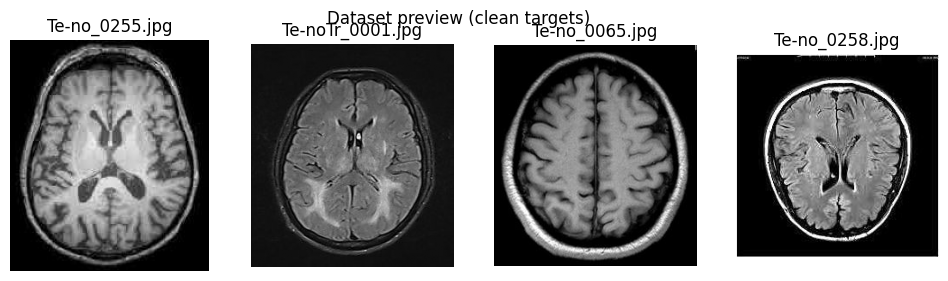

In [17]:
TF = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),  # -> [-1,1]
    ToTensorV2()
])

def read_gray(p):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None: raise FileNotFoundError(p)
    return img

class MRITestSet(Dataset):
    """Assume TEST_DIR holds clean images; synthesize Gaussian noise like training."""
    def __init__(self, root, noise_sigma=15.0):
        self.files = sorted(
            glob.glob(os.path.join(root, "**", "*.png"),  recursive=True) +
            glob.glob(os.path.join(root, "**", "*.jpg"),  recursive=True) +
            glob.glob(os.path.join(root, "**", "*.jpeg"), recursive=True)
        )
        if not self.files: raise FileNotFoundError(f"No images under {root}")
        self.noise_sigma = noise_sigma
        print(f"Found {len(self.files)} test images.")
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        clean = read_gray(p)
        noisy = np.clip(clean + np.random.normal(0, self.noise_sigma, clean.shape), 0, 255).astype(np.uint8)
        return TF(image=noisy)["image"], TF(image=clean)["image"], p

test_ds = MRITestSet(TEST_DIR, noise_sigma=15.0)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

# quick visual preview
sample_paths = random.sample(test_ds.files, k=min(4, len(test_ds)))
fig, ax = plt.subplots(1, len(sample_paths), figsize=(3*len(sample_paths), 3))
for i,p in enumerate(sample_paths):
    ax[i].imshow(read_gray(p), cmap="gray"); ax[i].set_title(os.path.basename(p)); ax[i].axis("off")
fig.suptitle("Dataset preview (clean targets)"); plt.show()


**Proof of training success (weights / manifest)**

In [18]:
print("Generator weights exist:", os.path.exists(MODEL_PATH))
manifest_path = os.path.join(RESULTS_DIR, "run_manifest.json")
if os.path.exists(manifest_path):
    with open(manifest_path) as f:
        print("Training manifest:\n", json.dumps(json.load(f), indent=2))
else:
    print("No manifest found — using presence of trained weights as evidence.")


Generator weights exist: True
No manifest found — using presence of trained weights as evidence.


In [20]:
import torch, os

ckpt = torch.load(MODEL_PATH, map_location=device)
# Handle: either a pure state_dict or a dict with "G"/"state_dict" keys
if isinstance(ckpt, dict) and any(k in ckpt for k in ["G", "gen", "generator", "state_dict"]):
    for k in ["G", "gen", "generator", "state_dict"]:
        if k in ckpt:
            ckpt_sd = ckpt[k]
            break
else:
    ckpt_sd = ckpt  # assume it's already a state_dict

# 1) Detect the checkpoint's input channels from the very first conv
first_key = None
for k in ckpt_sd.keys():
    if k.endswith("d1.0.weight"):   # our first down conv
        first_key = k
        break
if first_key is None:
    # fallback: pick any conv weight and infer in_c
    first_key = [k for k in ckpt_sd if k.endswith(".weight") and ckpt_sd[k].dim()==4][0]
in_c_ckpt = ckpt_sd[first_key].shape[1]
print("Checkpoint expects in_c =", in_c_ckpt)

# 2) Build a generator that matches the checkpoint's expected input channels
class UNetGenerator(nn.Module):
    def __init__(self, in_c=2, out_c=1):
        super().__init__()
        def down(i,o,bn=True):
            L=[nn.Conv2d(i,o,4,2,1,bias=False)]
            if bn: L.append(nn.BatchNorm2d(o))
            L.append(nn.LeakyReLU(0.2,True)); return nn.Sequential(*L)
        def up(i,o,drop=False):
            L=[nn.ConvTranspose2d(i,o,4,2,1,bias=False), nn.BatchNorm2d(o), nn.ReLU(True)]
            if drop: L.append(nn.Dropout(0.5));
            return nn.Sequential(*L)
        self.d1=down(in_c,64,False); self.d2=down(64,128)
        self.d3=down(128,256); self.d4=down(256,512)
        self.d5=down(512,512); self.d6=down(512,512)
        self.d7=down(512,512); self.b=down(512,512, bn=False)  # no BN at 1×1
        self.u1=up(512,512,True); self.u2=up(1024,512,True)
        self.u3=up(1024,512,True); self.u4=up(1024,512)
        self.u5=up(1024,256); self.u6=up(512,128)
        self.u7=up(256,64)
        self.out=nn.Sequential(nn.ConvTranspose2d(128,out_c,4,2,1), nn.Tanh())
    def forward(self,x):
        d1=self.d1(x); d2=self.d2(d1); d3=self.d3(d2); d4=self.d4(d3)
        d5=self.d5(d4); d6=self.d6(d5); d7=self.d7(d6); b=self.b(d7)
        u1=self.u1(b); u2=self.u2(torch.cat([u1,d7],1))
        u3=self.u3(torch.cat([u2,d6],1)); u4=self.u4(torch.cat([u3,d5],1))
        u5=self.u5(torch.cat([u4,d4],1)); u6=self.u6(torch.cat([u5,d3],1))
        u7=self.u7(torch.cat([u6,d2],1))
        return self.out(torch.cat([u7,d1],1))

G = UNetGenerator(in_c=in_c_ckpt, out_c=1).to(device)

# 3) Filter the checkpoint to only keys that exist AND have the same shape
model_sd = G.state_dict()
compatible = {k:v for k,v in ckpt_sd.items() if k in model_sd and v.shape == model_sd[k].shape}
missing = [k for k in model_sd.keys() if k not in compatible]
extra   = [k for k in ckpt_sd.keys() if k not in model_sd]

print(f"Loading {len(compatible)} tensors | {len(missing)} missing | {len(extra)} extra")
model_sd.update(compatible)
G.load_state_dict(model_sd, strict=False)
G.eval()
print("Generator loaded (strict=False).")


Checkpoint expects in_c = 2
Loading 82 tensors | 0 missing | 0 extra
Generator loaded (strict=False).


**Metrics (Baseline vs Model) + triplets**

In [22]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
psnr = PeakSignalNoiseRatio(data_range=2.0).to(device)   # tensors in [-1,1] → range=2
ssim = StructuralSimilarityIndexMeasure(data_range=2.0).to(device)

def denorm01(t): return (t.squeeze().detach().cpu().numpy()*0.5 + 0.5).clip(0,1)

def save_triplet(noisy_t, restored_t, clean_t, out_path, titles):
    fig, ax = plt.subplots(1,3,figsize=(9,3))
    for a,img,title in zip(ax,[denorm01(noisy_t), denorm01(restored_t), denorm01(clean_t)],titles):
        a.imshow(img, cmap="gray"); a.set_title(title); a.axis("off")
    fig.savefig(out_path, dpi=150, bbox_inches="tight"); plt.close(fig)

P_base, S_base, P_model, S_model = [], [], [], []

with torch.no_grad():
    for i,(noisy, clean, path) in enumerate(test_dl):
        noisy, clean = noisy.to(device), clean.to(device)

        # Baseline (noisy vs clean)
        P_base.append(psnr(noisy, clean).item())
        S_base.append(ssim(noisy, clean).item())

        # Model (denoise: zero mask)
        zmask = torch.zeros_like(noisy)
        x_cond = torch.cat([noisy, zmask], dim=1)
        restored = G(x_cond)

        P_model.append(psnr(restored, clean).item())
        S_model.append(ssim(restored, clean).item())

        # Save first 6 triplets
        if i < 6:
            base = os.path.splitext(os.path.basename(path[0]))[0]
            out_png = os.path.join(EVAL_DIR, f"triplet_denoise_{i+1}_{base}.png")
            save_triplet(noisy[0], restored[0], clean[0], out_png,
                         ["Input (noisy)", "Restored", "Clean"])

avg_base_psnr  = float(np.mean(P_base));  avg_base_ssim  = float(np.mean(S_base))
avg_model_psnr = float(np.mean(P_model)); avg_model_ssim = float(np.mean(S_model))

print(f"BASELINE  (Noisy→Clean): PSNR {avg_base_psnr:.2f} dB | SSIM {avg_base_ssim:.3f}")
print(f"UMR-GAN   (Restored→Clean): PSNR {avg_model_psnr:.2f} dB | SSIM {avg_model_ssim:.3f}")
print(f"DELTA                 : ΔPSNR {avg_model_psnr-avg_base_psnr:+.2f} dB | ΔSSIM {avg_model_ssim-avg_base_ssim:+.3f}")

metrics = {
    "baseline": {"PSNR": avg_base_psnr, "SSIM": avg_base_ssim},
    "model":    {"PSNR": avg_model_psnr, "SSIM": avg_model_ssim},
    "delta":    {"PSNR_dB": avg_model_psnr - avg_base_psnr,
                 "SSIM":    avg_model_ssim - avg_base_ssim},
    "n": len(test_ds)
}
with open(os.path.join(EVAL_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("Wrote:", os.path.join(EVAL_DIR, "metrics.json"))

BASELINE  (Noisy→Clean): PSNR 30.19 dB | SSIM 0.749
UMR-GAN   (Restored→Clean): PSNR 34.23 dB | SSIM 0.918
DELTA                 : ΔPSNR +4.04 dB | ΔSSIM +0.169
Wrote: /content/drive/MyDrive/UMR_GAN/results/eval/metrics.json


**Render accuracy table PNG + two showcase triplets**

In [23]:
# table PNG
df = pd.DataFrame({
    "PSNR (dB)": [metrics["baseline"]["PSNR"], metrics["model"]["PSNR"], metrics["delta"]["PSNR_dB"]],
    "SSIM":      [metrics["baseline"]["SSIM"], metrics["model"]["SSIM"], metrics["delta"]["SSIM"]],
}, index=["Baseline (Noisy→Clean)", "UMR-GAN", "Δ (Gain)"]).round(3)

print(df)
plt.figure(figsize=(6,1.8)); plt.axis('off')
plt.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns, loc='center')
plt.savefig(os.path.join(EVAL_DIR, "metrics_table.png"), dpi=200, bbox_inches="tight"); plt.close()
print("Wrote:", os.path.join(EVAL_DIR, "metrics_table.png"))

# single-sample denoise & inpaint panels
noisy_t, clean_t, _ = next(iter(test_dl))
noisy_t, clean_t = noisy_t.to(device), clean_t.to(device)

# denoise
zmask = torch.zeros_like(noisy_t)
x_denoise = torch.cat([noisy_t, zmask], dim=1)
with torch.no_grad(): out_d = G(x_denoise)
save_triplet(noisy_t[0], out_d[0], clean_t[0],
             os.path.join(EVAL_DIR, "sample_denoise_triplet.png"),
             ["Input (noisy)", "Restored (denoise)", "Clean"])

# inpaint (random hole)
b,_,H,W = noisy_t.shape
M = np.zeros((H,W), dtype=np.uint8)
rh, rw = int(H*0.2), int(W*0.2)
ry, rx = np.random.randint(0, H-rh+1), np.random.randint(0, W-rw+1)
M[ry:ry+rh, rx:rx+rw] = 1
M_t = torch.from_numpy(M).float().to(device).view(1,1,H,W)
masked = noisy_t.clone()
masked[M_t.bool()] = -1.0
x_inpaint = torch.cat([masked, M_t], dim=1)
with torch.no_grad(): out_i = G(x_inpaint)
save_triplet(masked[0].cpu(), out_i[0].cpu(), clean_t[0],
             os.path.join(EVAL_DIR, "sample_inpaint_triplet.png"),
             ["Input (masked)", "Restored (inpaint)", "Clean"])

print("Saved triplets to:", EVAL_DIR)

                        PSNR (dB)   SSIM
Baseline (Noisy→Clean)     30.191  0.749
UMR-GAN                    34.231  0.918
Δ (Gain)                    4.040  0.169
Wrote: /content/drive/MyDrive/UMR_GAN/results/eval/metrics_table.png
Saved triplets to: /content/drive/MyDrive/UMR_GAN/results/eval


At least one sample run that produces a verifiable prediction or visualization.



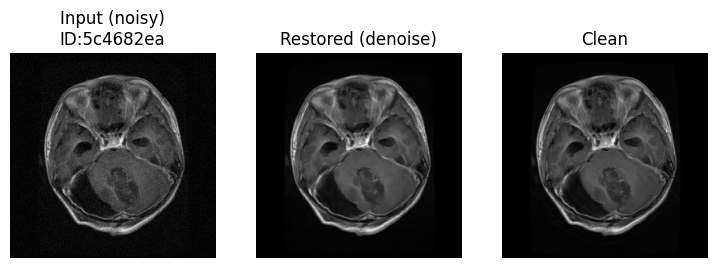

Sample path: /content/drive/MyDrive/Testing/glioma/Te-glTr_0000.jpg
Sample ID: 5c4682ea
Per-image PSNR: 36.00 dB | SSIM: 0.951
Saved sample visualization to: /content/drive/MyDrive/UMR_GAN/results/eval/single_sample_5c4682ea.png


In [24]:
# ==== Verifiable single-sample run (prediction + saved visualization) ====
import os, hashlib, torch, matplotlib.pyplot as plt
try:
    from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
except Exception:
    !pip install -q torchmetrics
    from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# 1) Pick a deterministic test image (first in sorted list)
assert len(test_ds) > 0, "Test set is empty."
sample_path = test_ds.files[0]
noisy_t, clean_t, _ = test_ds[0]                 # (1,H,W) in [-1,1]
noisy_t, clean_t = noisy_t.unsqueeze(0).to(device), clean_t.unsqueeze(0).to(device)

# 2) Build condition (denoise mode = zero mask; model expects 2 channels)
zmask  = torch.zeros_like(noisy_t)               # (1,1,H,W)
x_cond = torch.cat([noisy_t, zmask], dim=1)      # (1,2,H,W)

# 3) Run model
G.eval()
with torch.no_grad():
    restored = G(x_cond)

# 4) Metrics for THIS image (verifiable numbers)
psnr_one = PeakSignalNoiseRatio(data_range=2.0).to(device)
ssim_one = StructuralSimilarityIndexMeasure(data_range=2.0).to(device)
psnr_val = float(psnr_one(restored, clean_t).item())
ssim_val = float(ssim_one(restored, clean_t).item())

# 5) Stable ID for traceability in report
sid = hashlib.md5(sample_path.encode()).hexdigest()[:8]

# 6) Visualization (Input | Restored | Clean) + save exact file
def denorm01(t): return (t.squeeze().detach().cpu().numpy()*0.5 + 0.5).clip(0,1)
fig, ax = plt.subplots(1,3,figsize=(9,3))
titles = [f"Input (noisy)\nID:{sid}", "Restored (denoise)", "Clean"]
for a,im,t in zip(ax, [denorm01(noisy_t), denorm01(restored), denorm01(clean_t)], titles):
    a.imshow(im, cmap="gray"); a.set_title(t); a.axis("off")

os.makedirs(EVAL_DIR, exist_ok=True)
out_png = os.path.join(EVAL_DIR, f"single_sample_{sid}.png")
plt.savefig(out_png, dpi=150, bbox_inches="tight"); plt.show()

print("Sample path:", sample_path)
print("Sample ID:", sid)
print(f"Per-image PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.3f}")
print("Saved sample visualization to:", out_png)
